In [296]:
%matplotlib inline

import os,sys,inspect

PATH = '/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2'
sys.path.insert(0, PATH)

import pandas as pd
import numpy as np
import seaborn as sns

# sklearn modules
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import plot_confusion_matrix

from sklearn.pipeline import Pipeline
from keras.optimizers import SGD, Adam
from keras.layers import Dense, Input, Dropout, Activation
from keras import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold

import plotly.express as px
import matplotlib.pyplot as plt
from fma_metadata import utils

import warnings
warnings.filterwarnings('ignore')

#### Preprocessing

In [27]:
# read data: features
data = utils.load('/Users/gaetanoantonicchio/Desktop/dataset_DM2/fma_metadata/features.csv')

# read labels: song_happiness
labels = pd.read_csv('/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2/src/Data (cleaned)/Labels/song_happiness_labels.csv')
label= labels.set_index('track_id')

# merge labels with data
data = data.merge(labels, on='track_id')

# remove duplicate rows
data.drop_duplicates(keep=False, inplace=True)
# remove Null values (if there are)
data.dropna()

# reset index to track_id
data = data.set_index('track_id')

# view data
data.head()

,"(chroma_cens, kurtosis, 01)","(chroma_cens, kurtosis, 02)","(chroma_cens, kurtosis, 03)","(chroma_cens, kurtosis, 04)","(chroma_cens, kurtosis, 05)","(chroma_cens, kurtosis, 06)","(chroma_cens, kurtosis, 07)","(chroma_cens, kurtosis, 08)","(chroma_cens, kurtosis, 09)","(chroma_cens, kurtosis, 10)",...,"(tonnetz, std, 05)","(tonnetz, std, 06)","(zcr, kurtosis, 01)","(zcr, max, 01)","(zcr, mean, 01)","(zcr, median, 01)","(zcr, min, 01)","(zcr, skew, 01)","(zcr, std, 01)",valence
track_id,,,,,,,,,,,,,,,,,,,,,
2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,1.341231,...,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.0,2.089872,0.061448,happy
3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,0.619185,...,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.0,1.716724,0.069330,sad
5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,1.038546,...,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.0,2.193303,0.044861,happy
10,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,1.982386,...,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.0,3.542325,0.040800,happy
134,0.918445,0.674147,0.577818,1.281117,0.933746,0.078177,1.199204,-0.175223,0.925482,1.438509,...,0.016322,0.015819,4.731087,0.419434,0.064370,0.050781,0.0,1.806106,0.054623,happy


In [19]:
# check number of records per class
data.valence.value_counts()

sad      7724
happy    5405
Name: valence, dtype: int64

In [28]:
le = preprocessing.LabelEncoder()
data['valence'] = le.fit_transform(data['valence'])
data.valence.value_counts()

1    7724
0    5405
Name: valence, dtype: int64

LEGEND <BR>
1: sad <br>
0: happy

In [29]:
# remove labels from dataset 
labels = data[['valence']]
data.drop('valence', axis=1, inplace=True)

In [30]:
# preview labels
labels

,valence
track_id,
2,0
3,1
5,0
10,0
134,0
...,...
124857,0
124862,1
124863,1


## Partition Data into: Development set and Internal Test set

In [704]:
# split data in traning and test
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.30, random_state=42, stratify=labels) 

In [705]:
# normalize data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Create Neural Network : Keras

Fist I build a model to understand how it behaves with the data, and also to get an idea of what would be the search space in which start to look for the optimal hyperparameters.<br>
The model is initially trained on 70% of the development set and tested on the remaining 30% (which is the validation set). <br>
As per the Gold rule, the test set is never used in this phase. 

The model is trained with the following topology(518, 50, 50, 20, 1) with a dropout of 0.3 in each layer.
The training is carried out with Adam optimizer with a learning rate of 0.0015 and nesterov momentum of 0.5, over 1200 epochs.

In [706]:
input_dim = X_train.shape[1]
target_dim = y_train.shape[0]

print("____Development set____")
print(f"number of inputs: {input_dim}\nnumber of patterns: {X_train.shape[0]}")


____Development set____
number of inputs: 518
number of patterns: 9190


In [707]:
from sklearn.utils import shuffle

#shuffle data
X_train, y_train =  shuffle(X_train, y_train)


#### MLP with Dropout

In [708]:
help(Dense)

Help on class Dense in module tensorflow.python.keras.layers.core:

class Dense(tensorflow.python.keras.engine.base_layer.Layer)
 |  Dense(*args, **kwargs)
 |  
 |  Just your regular densely-connected NN layer.
 |  
 |  `Dense` implements the operation:
 |  `output = activation(dot(input, kernel) + bias)`
 |  where `activation` is the element-wise activation function
 |  passed as the `activation` argument, `kernel` is a weights matrix
 |  created by the layer, and `bias` is a bias vector created by the layer
 |  (only applicable if `use_bias` is `True`).
 |  
 |  Note: If the input to the layer has a rank greater than 2, then `Dense`
 |  computes the dot product between the `inputs` and the `kernel` along the
 |  last axis of the `inputs` and axis 1 of the `kernel` (using `tf.tensordot`).
 |  For example, if input has dimensions `(batch_size, d0, d1)`,
 |  then we create a `kernel` with shape `(d1, units)`, and the `kernel` operates
 |  along axis 2 of the `input`, on every sub-tensor

In [709]:
from tensorflow.keras import regularizers


def MLP():
    initializer = tf.keras.initializers.GlorotNormal()
    input_dim = X_train.shape[1]
    
    model = Sequential()
    model.add(Dense(50, activation='relu', input_dim=input_dim,kernel_initializer=initializer, kernel_regularizer=regularizers.l2(1e-1)))
    model.add(Dropout(0.2))
    model.add(Dense(20, activation='relu',kernel_initializer=initializer,kernel_regularizer=regularizers.l2(1e-1)))
    model.add(Dropout(0.2))
    #model.add(Dense(20, activation='tanh',kernel_initializer=initializer),activity_regularizer=l2(0.001))
    #model.add(Dropout(0.2))

    #linear activation
    model.add(Dense(1, activation='sigmoid',kernel_initializer=initializer))

    #compile the model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [710]:
model = MLP()

# define optimizer
sgd = SGD(learning_rate=0.001, momentum=0.9, nesterov=True
)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
# print model information
model.summary()

Model: "sequential_116"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_346 (Dense)            (None, 50)                25950     
_________________________________________________________________
dropout_146 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_347 (Dense)            (None, 20)                1020      
_________________________________________________________________
dropout_147 (Dropout)        (None, 20)                0         
_________________________________________________________________
dense_348 (Dense)            (None, 1)                 21        
Total params: 26,991
Trainable params: 26,991
Non-trainable params: 0
_________________________________________________________________


In [711]:
history = model.fit(X_train, y_train, epochs= 50, validation_split=0.3, batch_size=20, shuffle=True).history

Epoch 1/50
322/322 [==============================] - 1s 2ms/step - loss: 7.4766 - accuracy: 0.6055 - val_loss: 3.9237 - val_accuracy: 0.6536
Epoch 2/50
322/322 [==============================] - 1s 2ms/step - loss: 2.4796 - accuracy: 0.6580 - val_loss: 1.5247 - val_accuracy: 0.6594
Epoch 3/50
322/322 [==============================] - 1s 2ms/step - loss: 1.1381 - accuracy: 0.6754 - val_loss: 0.8791 - val_accuracy: 0.6884
Epoch 4/50
322/322 [==============================] - 1s 2ms/step - loss: 0.7743 - accuracy: 0.6925 - val_loss: 0.6995 - val_accuracy: 0.7145
Epoch 5/50
322/322 [==============================] - 1s 2ms/step - loss: 0.6708 - accuracy: 0.7051 - val_loss: 0.6468 - val_accuracy: 0.7058
Epoch 6/50
322/322 [==============================] - 1s 2ms/step - loss: 0.6392 - accuracy: 0.7200 - val_loss: 0.6298 - val_accuracy: 0.7298
Epoch 7/50
322/322 [==============================] - 1s 2ms/step - loss: 0.6273 - accuracy: 0.7197 - val_loss: 0.6205 - val_accuracy: 0.7229
Epoch 

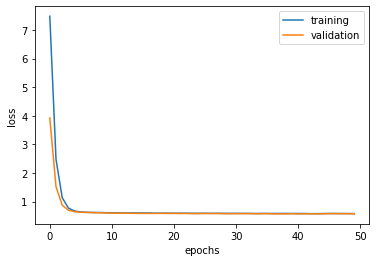

In [712]:
# training-validation loss
plt.plot(history['loss'], label='training')
plt.plot(history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

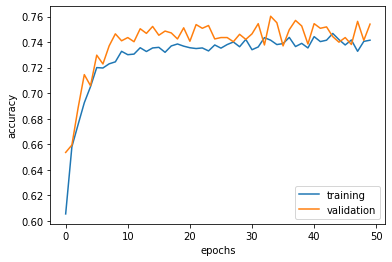

In [713]:
# training-validation accuracy
plt.plot(history['accuracy'], label='training')
plt.plot(history['val_accuracy'], label='validation')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

In [714]:
y_pred = mlp.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7456207159177456
F1-score [0.68628679 0.78608027]
              precision    recall  f1-score   support

           0       0.70      0.68      0.69      1622
           1       0.78      0.79      0.79      2317

    accuracy                           0.75      3939
   macro avg       0.74      0.74      0.74      3939
weighted avg       0.74      0.75      0.74      3939



# Random Search - Hyperparameter tuning

It will be performed first a coarse random search in order to restric the search space. The best model will be then fed to a fine random search which will fine tune the hyperparameters found by the coarse search.

In [149]:
#help(MLPClassifier)

### Coarse Random- Search

In [148]:
# coarse grid search
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import RandomizedSearchCV
from random import randint
parameter_space = {
    'hidden_layer_sizes': [(50,50), (100,50), (50,), (20,20,20)],
    'activation': ['tanh','logistic','relu'],
    'solver': ['adam'],
    'alpha': [0.001, 0.01, 0.0001, 0.03],
    'batch_size':[1, 200, 120, 50],
    'learning_rate': ['constant','adaptive'],
    'learning_rate_init':[0.001, 0.01, 0.1, 0.2],
   
}

mlp = MLPClassifier(max_iter=100, shuffle=True, random_state=42, warm_start=True)

rnd = RandomizedSearchCV(estimator=mlp, param_distributions=parameter_space, n_iter=50, cv=5, verbose=True)
rnd.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 33.3min finished


RandomizedSearchCV(cv=5,
                   estimator=MLPClassifier(max_iter=100, random_state=42,
                                           warm_start=True),
                   n_iter=50,
                   param_distributions={'activation': ['tanh', 'logistic',
                                                       'relu'],
                                        'alpha': [0.001, 0.01, 0.0001, 0.03],
                                        'batch_size': [1, 200, 120, 50],
                                        'hidden_layer_sizes': [(50, 50),
                                                               (20, 20), (50,),
                                                               (20, 20, 20)],
                                        'learning_rate': ['constant',
                                                          'adaptive'],
                                        'learning_rate_init': [0.001, 0.01, 0.1,
                                                               0.2]

In [144]:
print('Best parameters found:\n', rnd.best_params_)
print('Best score found:\n', rnd.best_score_)

Best parameters found:
 {'solver': 'adam', 'learning_rate_init': 0.0636513821518595, 'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'alpha': 0.04778956162450835, 'activation': 'logistic'}
Best score found:
 0.9475632796993405


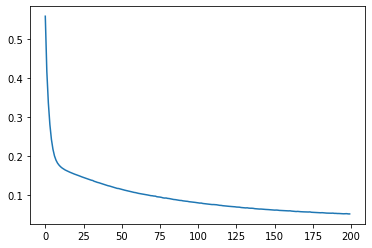

In [150]:
plt.plot(clf.loss_curve_)
plt.show()

### Fine random-search 

In [ ]:
# fine grid search 

parameter_space = {
    'hidden_layer_sizes': [(50,50), (20,20), (50,), (20,20,20)],
    'activation': ['tanh','logistic','relu'],
    'solver': ['adam'],
    'alpha': [random.uniform(0.001, 0.02)],
    'batch_size':[1, 200, 120, 50],
    'learning_rate': ['constant','adaptive'],
    'learning_rate_init':[random.uniform(0.001,0.2)],
   
}

mlp = MLPClassifier(max_iter=100, shuffle=True, random_state=42, warm_start=True)

rnd = RandomizedSearchCV(estimator=mlp, param_distributions=parameter_space, n_iter=50, cv=5, verbose=True)
rnd.fit(X_train, y_train)